# Pre-processing

In this notebook, we will prepare the data for a future training.

Basically what we have now is the raw data from Sentinel2 and the GeoTIFF file from CORINE.

Both have different resolutions and coverage areas. As the best CORINE resolution is 100m we will work with it.

We therefore want to follow these steps:
1. Compute the feature maps we are interested in for S2A images
2. Cut the images into a stadardized format of 256x256 pixels where each pixel represents 100m
3. Create multi layered images with those features
4. Create the corresponding label mask from CORINE data and S2A SCL layer
5. Save this data under a convenient format for training

## Feature maps

The conclusion of [Sentinel-2 Imagery Processing for Tree LoggingObservations on the Białowie  ̇za Forest WorldHeritage Site](https://www.mdpi.com/1999-4907/11/8/857) states that:

> Out of eight chosen radiometric vegetation indices,three were successful in the depiction of forest cover change: RVI, NDVI, and MTCI. They showedsignificant  canopy  cover  decrease  over  the  felling  area.   Additionally,  MTCI’s  behavior  was  nottendentious, as its value increased for the dense forest pinpoint. This fact could indicate high sensitivityto canopy cover changes and, hence, high potential for deforestation observation.

We therefore use those features to train our model:
* [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) $= \frac{8 - 4}{8 + 4}$
* [RVI](https://www.indexdatabase.de/db/i-single.php?id=72) $= \frac{8}{4}$
* [MTCI](https://www.indexdatabase.de/db/i-single.php?id=169) $= \frac{6 - 5}{5 - 6}$

Where `4`, `5`, `6` and `8` corresponds to Sentinel2 band indices.

Optionnaly we could compute:

* NDVI Homogeneity
* NDVI entropy

The two later features are computed by computing the [Gray Level Co-occurence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix) and then applying the following formulas to it:

_Homogeneity_: $\sum_j{\sum_i{\frac{P[i, j]}{1 - |i - j|}}}$

_Entropy_: $\sum_j{\sum_i{P[i,j]\log P[i,j]}}$

![SCL values](../data/assets/scl.png)

We will therefore be filtering out classes `0`, `1`, `8`, `9`, `10` and `11`.

Let us start with some helper functions.

In [1]:
from rasterio.warp import reproject, transform_bounds
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from rasterio.crs import CRS
import numpy as np
import rasterio
import os

raw_data_path = '../data/s2a/'

def get_img_dir(tile, res='R60m'):
    img_dir = os.path.join(raw_data_path, tile, 'GRANULE')
    return os.path.join(img_dir, os.listdir(img_dir)[0], 'IMG_DATA', res)

def find_band(imgs, name):
    return next(filter(lambda x: name in x, imgs))

Now, we want to be able to load Tiff images and rescale them so that the resolution matches the resolution of CORINE's dataset (aka. 100m/pixel).

In [49]:
def load_band(path, resampling_method=0, scale=None):
    t = rasterio.open(path)
    # First we ensure the proper CRS is used
    if t.crs != CRS.from_epsg(3035):
        data, transform = reproject(rasterio.band(t, [i+1 for i in range(t.count)]), dst_crs=CRS.from_epsg(3035))
    
    # Second we resample the data to match CORINE's scale
    if scale:
        data = zoom(data, [1, scale, scale], order=resampling_method) # Becaused the SCL mask is classes, we should use nearest interpolation
        transform = t.transform * t.transform.scale(
            (t.width / data.shape[-1]),
            (t.height / data.shape[-2])
        )
    crs, bounds = t.crs, t.bounds
    t.close()
    return data, (crs, transform, bounds)

Let's now check what those images look like. Here we will open the TCI image provided by the ESA. TCI stands for True Color Image and is the human understandable RGB image provided.

(3, 2120, 2108)
(3, 1272, 1265)


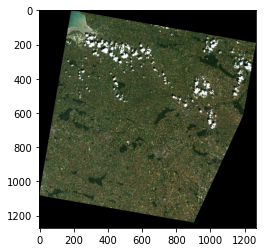

In [56]:
tile = os.listdir(raw_data_path)[0] # Let's use the first tile
img_dir = get_img_dir(tile)
imgs = os.listdir(os.path.join(img_dir))
tci_img = find_band(imgs, 'TCI')
tci_data, _ = load_band(os.path.join(img_dir, tci_img), 0, scale=60/100)
plt.imshow(np.rollaxis(tci_data, 0, 3))

Wonder why the image appears in a funny shape and not a square ? This is due to the [reprojection](https://rasterio.readthedocs.io/en/latest/topics/reproject.html#reprojecting-a-geotiff-dataset) of the data.

Next, we define the functions that will compute the features on the images. As explained before we need to load bands 4 and 8 for that.

In [3]:
epsilon = 1e-15

def ndvi(b04, b08):
    return (b08 - b04) / (b08 + b04 + epsilon)

def rvi(b04, b08):
    return b08 / (b04 + epsilon)

def mtci(b05, b06):
    return (b06 - b05) / (b05 - b06 + epsilon)

## Label extraction

We now want to be able to provide labels to a machine learning algorithm that we wil be implementing later. Thise labels will be extracted fro; the CORINE dataset. Please check Notebook 1 if you do not have the data downloaded already.

Our requirements here are pretty straight forward. We want to load the dataset, transform it so that it gives labels as `Forest` / `Not Forest`

But first let's have a look at the data.

Height: 46000, Width: 65000, Layers 1


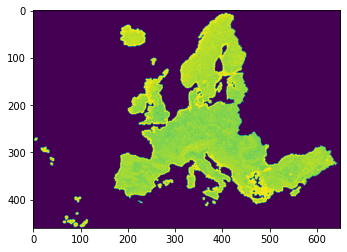

In [4]:
corine_path = '../data/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif'

corine_dataset = rasterio.open(corine_path)
print(f'Height: {corine_dataset.height}, Width: {corine_dataset.width}, Layers {corine_dataset.count}')
label_data = corine_dataset.read(1)
plt.imshow(corine_dataset.read(out_shape=(1, corine_dataset.height//100, corine_dataset.width//100))[0, :, :])
label_crs = corine_dataset.crs
label_transform = corine_dataset.transform
plt.show()

Looks like Europe no ? 🇪🇺

Now we want to filter this data to show a different map. Instead of the 44 different original classes, we will just keep `1` for forest and `0` if not. As seen in Notebook 1 we consider forest any pixel valued with `311`, `312` or `313`.

According to this [spreadsheet](https://www.eea.europa.eu/data-and-maps/data/corine-land-cover-2000-clc2000-100-m-version-9-2007/corine-land-cover-2000-classes-and-rgb-color-codes/clc2000legend.xls), those classes have values 23, 24 and 25 in the TIF file.

In [5]:
forest_map = np.zeros(label_data.shape, dtype=np.int8)

# We initialized the map with zeros and add 1s class by class as it is more memory efficient this way
forest_map[np.where(label_data == 23)] = 1.
forest_map[np.where(label_data == 24)] = 1.
forest_map[np.where(label_data == 25)] = 1.

del label_data

print(f'{100 * np.sum(forest_map) / forest_map.size:.2f}% of pixels are forest.')

5.74% of pixels are forest.


Now that we have our target map, we need to have a handy way to cut it to given boundaries. We will later use this tool to get only the sub-map that matches our sentinel2 tiles.

In [6]:
def convert_layer(src_layer, src_crs, src_transform, dst_crs, src_bounds):
    destination, dst_transform = reproject(
            src_layer,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )
    return destination, dst_transform

def crop_corine(corine_dataset, forest_map, bounds):
    left, bottom, right, top = bounds
    x0, y0 = corine_dataset.index(left, top)
    x1, y1 = corine_dataset.index(right, bottom)
    return forest_map[y0:y1, x0:x1]
    
# 2. Crop CORINE using index()
# 3. Plot example to check

We declare here the function that will, given a tile, compute the features, mask it and save it into a multi layer image.

In [59]:
def process_tile(tile, corine_dataset, forest_map, label_crs, label_transform):
    print(f' Working on tile {tile}')
    img_dir = get_img_dir(tile) # First we get the path to the 60m res folder
    imgs = [os.path.join(img_dir, img) for img in os.listdir(img_dir)] # We list available images


    # We load the SCL band from the 60m res folder
    scl_img = find_band(imgs, 'SCL')
    scl_layer, (src_crs, src_transform, src_bounds) = load_band(scl_img, Resampling.nearest, scale=60/100) # We use nearest since SCL represents classes
    
    # Now we load bands 4 and 8 from the 10m res folder
    img_dir = get_img_dir(tile, res='R10m')
    imgs = [os.path.join(img_dir, img) for img in os.listdir(img_dir)] # We list available images
    b04_img = find_band(imgs, 'B04')
    b04, _ = load_band(b04_img, Resampling.bilinear, scale=10/100)
    b08_img = find_band(imgs, 'B08')
    b08, _ = load_band(b08_img, Resampling.bilinear, scale=10/100)
    
    # Now we load bands 5 and 6 from the 20m res folder
    img_dir = get_img_dir(tile, res='R20m')
    imgs = [os.path.join(img_dir, img) for img in os.listdir(img_dir)] # We list available images
    b05_img = find_band(imgs, 'B05')
    b05, _ = load_band(b05_img, Resampling.bilinear, scale=20/100)
    b06_img = find_band(imgs, 'B06')
    b06, _ = load_band(b06_img, Resampling.bilinear, scale=20/100)
    
    #We can now compute NDVI and SAVI
    ndvi_layer = ndvi(b04, b08)
    rvi_layer = rvi(b04, b08)
    mtci_layer = mtci(b05, b06)

    # We want now to prepare those 3 layers to match the CORINE map CRS
    #print('Foo', np.mean(ndvi_layer), np.std(ndvi_layer), ndvi_layer.shape)
    #ndvi_layer, transform = convert_layer(ndvi_layer, src_crs, src_transform, label_crs, src_bounds)
    #rvi_layer, _ = convert_layer(rvi_layer, src_crs, src_transform, label_crs, src_bounds)
    #mtci_layer, _ = convert_layer(mtci_layer, src_crs, src_transform, label_crs, src_bounds)
    plt.imshow(np.clip(ndvi_layer[0], 0, 4))
    print('NDVI', np.mean(ndvi_layer), np.std(ndvi_layer), ndvi_layer.shape)
    print('RVI', np.mean(rvi_layer), np.std(rvi_layer), rvi_layer.shape)
    print('MTCI', np.mean(mtci_layer), np.std(mtci_layer), mtci_layer.shape)
    return None
    
    # Now we fetch a cropped forest map
    print(forest_map.shape)
    dst_bounds = transform_bounds(src_crs, label_crs, src_bounds.left, src_bounds.bottom, src_bounds.right, src_bounds.top)
    target = crop_corine(corine_dataset, forest_map, dst_bounds)
    print(target.shape)
    #plt.imshow(target)
    plt.show()
    
    return None

All left to do now is to run the `process_tile` function on all tiles available.

 Working on tile S2A_MSIL2A_20200625T110631_N0214_R137_T30UXU_20200625T122333.SAFE
(1, 2120, 2108)
(1, 1272, 1265)
(1, 12718, 12647)
(1, 1272, 1265)
(1, 12718, 12647)
(1, 1272, 1265)
(1, 6359, 6323)
(1, 1272, 1265)
(1, 6359, 6323)
(1, 1272, 1265)
NDVI 0.9682423808085897 14.901084431004595 (1, 1272, 1265)
RVI 1242946284.8582144 1576670864450.822 (1, 1272, 1265)
MTCI 13.420290978579194 474.0708470376482 (1, 1272, 1265)


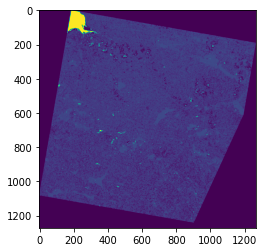

In [60]:
tiles = os.listdir(raw_data_path)

for tile in tiles:
    process_tile(tile, corine_dataset, forest_map, label_crs, label_transform)
    break